<a href="https://colab.research.google.com/github/mattia01017/CNN-cell-segmentation/blob/main/CNNcellSegm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: CNN-based segmentation of cells in multi-modal microscopy images

Contact: Karl Rohr (Heidelberg University K.Rohr@dkfz-heidelberg.de)

### Introduction

Cell segmentation is a central task in biomedical image analysis and enables counting the cell number, quantifying single-cell fluorescence intensity, and tracking of cells to analyze cell motion. Challenges are high variation of cell shape and image intensity, strong image noise, low image contrast, and high cell density. Deep learning methods for cell segmentation in microscopy data show promising results.

### Goal

The goal of this project is to develop a Convolutional Neural Network (CNN) to automatically segment cells in microscopy images. A modified 2D U-Net model (Ronneberger et al., MICCAI 2015, Falk et al., Nature Methods 2019) will be implemented and applied to image data from different imaging modalities comprising fluorescence, differential interference contrast (DIC), and phase-contrast microscopy. Different versions of the network model will be generated by training on data from individual imaging modalities as well as a combination of different imaging modalities. The trained models are applied to the different datasets, and the segmentation accuracy will be quantified by a performance metric. The experimental results are analyzed and a comparison of the different network models will be carried out.

### Data and model

The [2D U-Net model](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) will be used as a basis. Zero-padding (SAME padding) in the convolution layers should be included to ensure that the output size of the network is the same as the input size. This eliminates the need for cropping and resizing of the images in the original model. Experiments with different network configurations should be performed (e.g., different number of layers). Besides using a Cross-Entropy Loss as in the original model, a Dice Loss or a combination of both losses should be investigated. Also, loss weighting as in the original model should be tested. Existing implementations of the U-Net can be used as inspiration.

The network model should be applied to [datasets from the Cell Tracking Challenge](https://celltrackingchallenge.net/2d-datasets/) (Ulman et al., Nature Methods 2017) comprising 2D time-lapse microscopy image data of three different imaging modalities:
1. Fluorescence microscopy: HeLa cells stably expressing H2b-GFP ([download](http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip))
2. Differential interference contrast (DIC) microscopy: HeLa cells on a flat glass ([download](http://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip))
3. Phase-contrast microscopy: Glioblastoma-astrocytoma U373 cells on a polyacrylamide substrate ([download](http://data.celltrackingchallenge.net/training-datasets/PhC-C2DH-U373.zip))

Each dataset consists of two image sequences from which single images should be used as samples. The images can be found in the folders `01` and `02`. Since the "gold truth" provided in the folders `01_GT/SEG` and `02_GT/SEG` is not available for all single images or cells, the "silver truth" in `01_ST/SEG` or `02_ST/SEG`can be used. More information on the datasets can be found [here](https://celltrackingchallenge.net/). One of the two image sequences should be used for training and the other for testing. The labels are instance labels (with a different ID for each cell), which need to be converted to semantic labels (foreground-background).

Different versions of the network model should be generated by training on data from individual imaging modalities as well as a combination of different imaging modalities. A comparison of the different network models should be performed. The Jaccard Index (Intersection over Union) can be used as segmentation performance metric. A strategy needs to be found to deal with large image sizes (e.g., using image resizing or image tiling as in the original model). To improve the segmentation result, different preprocessing and data augmentation strategies can be studied. Information on deep learning for image segmentation and the U-Net is provided in the lecture (Karl Rohr).


### References
Ronneberger 0, Fischer P, Brox T. (2015) [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28), MICCAI 2015, 234–241

Falk T, Brox T, Ronneberger O et al. (2019) [U-Net: deep learning for cell counting, detection, and morphometry](https://www.nature.com/articles/s41592-018-0261-2), Nature Methods 16, 67-70

Ulman V, Maška M, Harder N, Rohr K, Kozubek M, Ortiz-de-Solorzano C, et al. (2017) [An objective comparison of cell-tracking algorithms](https://www.nature.com/articles/nmeth.4473), Nature Methods 14, 1141–1152




---

# Setup and dataset download

In [1]:
!pip install imagecodecs
!curl https://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip -o Fluo-N2DL-HeLa.zip
!curl https://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip -o DIC-C2DH-HeLa.zip
!curl https://data.celltrackingchallenge.net/training-datasets/PhC-C2DH-U373.zip -o PhC-C2DH-U373.zip
!unzip Fluo-N2DL-HeLa.zip > /dev/null
!unzip DIC-C2DH-HeLa.zip > /dev/null
!unzip PhC-C2DH-U373.zip > /dev/null
!rm *.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 40.2 MB/s eta 0:00:00:00:0100:01
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  190M  100  190M    0     0  19.3M      0  0:00:09  0:00:09 --:--:-- 24.6M990k      0  0:01:05  0:00:02  0:01:03 2989k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.5M  100 39.5M    0     0  10.5M      0  0:00:03  0:00:03 --:--:-- 10.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41.4M  100 41.4M    0     0  11.5M      0  0:00:03  0:00:03 --:--:-- 11.5M


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import scipy.ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import Compose
from torchvision.io import read_image
from skimage.transform import resize
from pathlib import Path
from sklearn.model_selection import KFold
from itertools import product
from functools import partial
import cv2

# for reproducibility
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Network will run on '{device}'.")


def load_images(path, n=None, seed=random_seed):
  files = sorted(path.glob("*.tif"))

  random_state = np.random.RandomState(seed)
  if n is not None and n < len(files):
    files = random_state.choice(files, n, replace=False)

  return np.stack([
      skimage.io.imread(fn)
      for fn in files
  ])


def get_slices(dataset_shape, patch_size, stride):
    x, y = dataset_shape
    p_x, p_y = patch_size
    s_x, s_y = stride

    x_indices = np.arange(0, x - p_x + 1, s_x)
    if x_indices[-1] + p_x < x:
        x_indices = np.append(x_indices, x - p_x)

    y_indices = np.arange(0, y - p_y + 1, s_y)
    if y_indices[-1] + p_y < y:
        y_indices = np.append(y_indices, y - p_y)

    slices = []
    for idx_x in x_indices:
        for idx_y in y_indices:
            slices.append((
                slice(idx_x, idx_x + p_x),
                slice(idx_y, idx_y + p_y)
            ))
    return slices


def plot_img(ax, data, title="", cmap="gray"):
  ax.imshow(data, cmap=cmap)
  ax.set_title(title)

Network will run on 'cuda'.


# Dataset import and data augmentation

We define a dataset for each image. A dataset will contain slices of the same image, possibly with a transformation applied

In [3]:
class CellImageDataset(Dataset):
  def __init__(self,
              image,
              label,
              patch_size,
              stride,
              padding,
              transforms,
              phase):
    self.phase = phase
    self.transforms = transforms

    self.image = image
    self.label = label

    self.image_shape = self.image.shape
    self.padding = padding
    if padding is not None:
        self.image = np.pad(self.image, pad_width=((padding[0], padding[0]), (padding[1], padding[1])), mode="reflect")
        self.label = np.pad(self.label, pad_width=((padding[0], padding[0]), (padding[1], padding[1])), mode="reflect")

    self.slices = get_slices(self.image.shape, patch_size, stride)

  def __len__(self,):
      return len(self.slices)

  def __getitem__(self, index):
      sl = self.slices[index]

      x = self.image[sl]
      y = self.label[sl]

      x, y = self.transforms(x, y)

      if self.phase == "test":
          return x, y, sl
      else:
          return x, y


def load_datasets(path: Path, phase, n=None, seed=random_seed, **dataset_args):
    if phase == "train":
        img_dir = path / "01"
        labels_dir = path / "01_ST" / "SEG"
    elif phase == "test":
        img_dir = path / "02"
        labels_dir = path / "02_ST" / "SEG"


    if n == 1:
        return CellImageDataset(
            image=load_images(img_dir, n, seed)[0],
            label=load_images(labels_dir, n, seed)[0],
            phase=phase,
            **dataset_args
        )
    return ConcatDataset([
        CellImageDataset(
            image=image,
            label=label,
            phase=phase,
            **dataset_args
        )
        for image, label in zip(load_images(img_dir, n, seed), load_images(labels_dir, n, seed))
    ])

Below the transformation methods, applied to an image with a given probability

In [4]:
def cast(type_):
  return lambda x: x.astype(type_)

def to_tensor():
  return lambda x: (
       torch.from_numpy(x.copy()).unsqueeze(0)
       if len(x.shape) == 2
       else torch.from_numpy(x.copy())
  )

def normalize(min=None, max=None, eps=1e-8):
  return lambda x: (
      (x - min) / (max - min + eps)
      if min is not None and max is not None
      else (x - x.min()) / (x.max() - x.min() + eps)
  )

def instance2Semantic():
  return lambda x: (x > 0).astype(int)

def rotate_90():
  def transform(random_state, x):
    k = random_state.randint(1,4)
    return np.rot90(x,k)
  return transform

def contrast(scale):
    def transform(random_state, x):
      lam = random_state.uniform(np.max((0, 1 - scale)), 1 + scale)
      return np.clip(x * lam, 0, 255)
    return transform

def brightness(scale):
  def transform(random_state, x):
    lam = 255 * scale * random_state.uniform(-1,1)
    return np.clip(x + lam, 0, 255)
  return transform

def elastic_deformation(grid_size, sigma, order):
  def transform(random_state, x):
    h,w = x.shape

    dx = random_state.randn(*[grid_size, grid_size]) * sigma
    dy = random_state.randn(*[grid_size, grid_size]) * sigma

    dx = resize(dx, x.shape, preserve_range=True, order = 3)
    dy = resize(dy, x.shape, preserve_range=True, order = 3)

    idx_x, idx_y = np.meshgrid(np.arange(h), np.arange(w))

    coordinates = idx_y + dy, idx_x + dx

    return scipy.ndimage.map_coordinates(x, coordinates, order = order,
                                         mode = "reflect", prefilter=False)
  return transform

def flip():
  def transform(random_state, x):
    return np.flip(x, 1 if random_state.random() < 0.5 else 0)
  return transform

def rotate(angle_range, mode="mirror", order=0, reshape=False):
  def transform(random_state, x):
    return scipy.ndimage.rotate(x, random_state.uniform(angle_range[0], angle_range[1]),
                                mode=mode, order=order, reshape=reshape)
  return transform


class ImageLabelTransform:
  max_seed = 2**32

  def __init__(self,
              pre_transf_image,
              pre_transf_label,
              post_transf_image,
              post_transf_label,
              image_only_transforms,
              transforms,
              p,
              random_state) -> None:
     self.p = p
     self.transforms = transforms
     self.image_only_transforms = image_only_transforms
     self.random_state = random_state

     self.pre_transf_image = pre_transf_image
     self.pre_transf_label = pre_transf_label
     self.post_transf_image = post_transf_image
     self.post_transf_label = post_transf_label

  def __call__(self, x, y):
    x = self.pre_transf_image(x)
    y = self.pre_transf_label(y)

    for transform in self.image_only_transforms:
      if self.random_state.random() < self.p:
        seed = self.random_state.randint(self.max_seed)
        x = transform(np.random.RandomState(seed), x)

    for transform in self.transforms:
      if self.random_state.random() < self.p:
        seed = self.random_state.randint(self.max_seed)
        x = transform(np.random.RandomState(seed), x)
        y = transform(np.random.RandomState(seed), y)

    x = self.post_transf_image(x)
    y = self.post_transf_label(y)
    return x, y

In [5]:
execution_probability = 0.1

train_transf = ImageLabelTransform(
    pre_transf_image=cast(np.float32),
    pre_transf_label=instance2Semantic(),
    post_transf_image=Compose([
        normalize(min=0, max=255),
        to_tensor()
    ]),
    post_transf_label=to_tensor(),
    image_only_transforms=[
        contrast(scale=0.2),
        brightness(scale=0.2)
    ],
    transforms=[
        rotate_90(),
        rotate(angle_range=[-10,10], order=2),
        flip(),
        elastic_deformation(grid_size=3, sigma=10, order=3),
    ],
    random_state=np.random.RandomState(random_seed),
    p=execution_probability
)

test_transf = ImageLabelTransform(
    pre_transf_image=cast(np.float32),
    pre_transf_label=instance2Semantic(),
    post_transf_image=Compose([normalize(min=0, max=255), to_tensor()]),
    post_transf_label=to_tensor(),
    image_only_transforms=[],
    transforms=[],
    random_state=np.random.RandomState(random_seed),
    p=0
)

Here we import the data and create the data loaders

In [6]:
batch_size = 4
patch_size = (256,256)
stride = (128,128)
padding = (0,0)

fluo_data = load_datasets(
    Path("Fluo-N2DL-HeLa"),
    n=10,
    phase="train",
    patch_size=patch_size,
    stride=stride,
    padding=padding,
    transforms=train_transf,
)

phc_data = load_datasets(
    Path("PhC-C2DH-U373"),
    n=10,
    phase="train",
    patch_size=patch_size,
    stride=stride,
    padding=padding,
    transforms=train_transf,
)

dic_data = load_datasets(
    Path("DIC-C2DH-HeLa"),
    n=10,
    phase="train",
    patch_size=patch_size,
    stride=stride,
    padding=padding,
    transforms=train_transf,
)

Below the plots of some examples took from each of the 3 given datasets

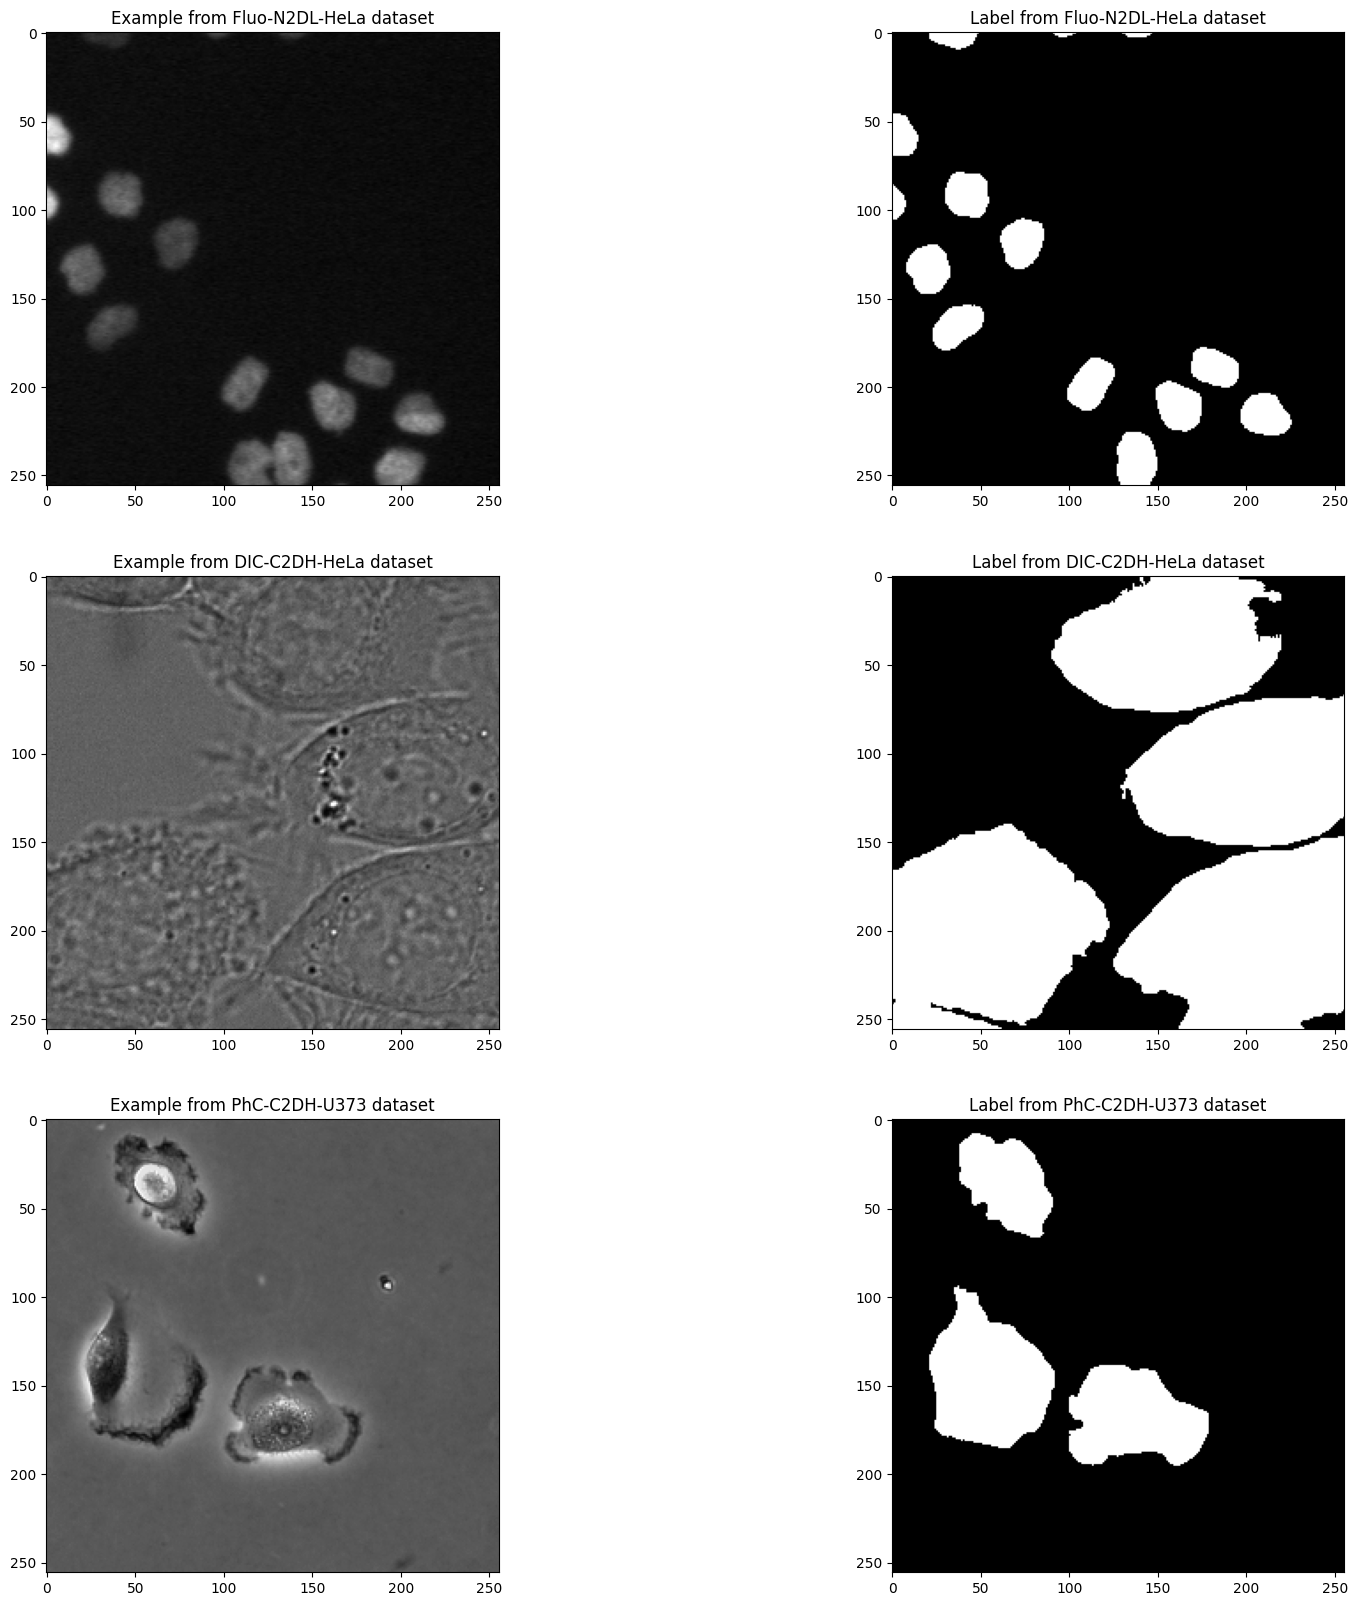

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

fluo_x, fluo_y = fluo_data[1]
dic_x, dic_y = dic_data[1]
phc_x, phc_y = phc_data[1]

plot_img(axs[0, 0], fluo_x[0], "Example from Fluo-N2DL-HeLa dataset")
plot_img(axs[0, 1], fluo_y[0], "Label from Fluo-N2DL-HeLa dataset")
plot_img(axs[1, 0], dic_x[0], "Example from DIC-C2DH-HeLa dataset")
plot_img(axs[1, 1], dic_y[0], "Label from DIC-C2DH-HeLa dataset")
plot_img(axs[2, 0], phc_x[0], "Example from PhC-C2DH-U373 dataset")
plot_img(axs[2, 1], phc_y[0], "Label from PhC-C2DH-U373 dataset")

plt.show()

# Build and train U-net

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size, padding, pooling, dropout):
        super(EncoderLayer, self).__init__()
        if pooling:
            self.pooling = nn.MaxPool2d(2)
        else:
            self.pooling = None

        self.block = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(ch_out, track_running_stats=False),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Conv2d(ch_out, ch_out, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(ch_out, track_running_stats=False),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        )

    def forward(self,x):
        if self.pooling is not None:
            x = self.pooling(x)
        x = self.block(x)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, ch_in, ch_out, kernel_size, padding, dropout, skip_mode="concat", upsampling_mode="transpose"):
        super(DecoderLayer, self).__init__()

        assert upsampling_mode in ["transpose", "interpolate"], f"Upsampling has to be either 'transpose' or 'interpolate' but got '{upsampling_mode}'"
        assert skip_mode in ["concat", "add", "none"], f"Skip-connection has to be either 'none', 'add' or 'concat' but got '{skip_mode}'"

        self.skip_mode = skip_mode
        self.upsampling_mode = upsampling_mode

        if self.upsampling_mode == "transpose":
            self.up = nn.ConvTranspose2d(ch_in, ch_out, kernel_size=2, stride = 2)
        else:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0)

        if self.skip_mode == "concat":
            ch_hidden = ch_out + ch_out
        elif self.skip_mode == "add":
            ch_hidden = ch_out
        elif self.skip_mode == "none":
            ch_hidden = ch_out

        self.block = nn.Sequential(
            nn.Conv2d(ch_hidden, ch_out, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(ch_out, track_running_stats=False),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Conv2d(ch_out, ch_out, kernel_size=kernel_size, stride=1, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(ch_out, track_running_stats=False),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        )

    def forward(self,x, skip_features):
        if self.upsampling_mode == "transpose":
            x = self.up(x)
        elif self.upsampling_mode == "interpolate":
            x = self.up(x)
            x = self.conv(x)

        if self.skip_mode == "concat":
            x = self.block(torch.cat((x, skip_features), 1))
        elif self.skip_mode == "add":
            x = self.block(torch.add(x, skip_features))
        elif self.skip_mode == "none":
            x = self.block(x)

        return x


class UNet2d(nn.Module):
    def __init__(self,
              input_dim,
              output_dim,
              encoder_layer=EncoderLayer,
              decoder_layer=DecoderLayer,
              hidden_layers=5,
              first_hidden_dim=64,
              kernel_size=3,
              skip_mode="concat",
              upsampling_mode="transpose",
              dropout=0):
    
          super(UNet2d, self).__init__()
        
          assert hidden_layers > 0, "UNet2d requires at least one hidden layer"
        
          hidden_dims = [first_hidden_dim*(2**i) for i in range(hidden_layers)]
          padding = kernel_size//2
        
          #Assembling the encoder
          encoder = []
          for i in range(len(hidden_dims)):
              if i == 0:
                  ch_in = input_dim
                  ch_out = hidden_dims[i]
                  encoder.append(encoder_layer(ch_in, ch_out, kernel_size=kernel_size, padding=padding, pooling=False, dropout=0))
              elif i == (len(hidden_dims) - 1):
                  ch_in = hidden_dims[i-1]
                  ch_out = hidden_dims[i]
                  encoder.append(encoder_layer(ch_in, ch_out, kernel_size=kernel_size, padding=padding, pooling=True, dropout=dropout))
              else:
                  ch_in = hidden_dims[i-1]
                  ch_out = hidden_dims[i]
                  encoder.append(encoder_layer(ch_in, ch_out, kernel_size=kernel_size, padding=padding, pooling=True, dropout=0))
          self.encoder = nn.ModuleList(encoder)
        
          #Assembling the decoder
          decoder = []
        
          #Reversing the order of the hidden dims, since the decoder reduces the number of channels
          hidden_dims_rev = hidden_dims[::-1]
        
          for i in range(len(hidden_dims_rev) - 1):
              ch_in = hidden_dims_rev[i]
              ch_out = hidden_dims_rev[i+1]
              decoder.append(decoder_layer(ch_in, ch_out, kernel_size=kernel_size, padding=padding, dropout=0, skip_mode=skip_mode, upsampling_mode=upsampling_mode))
          self.decoder = nn.ModuleList(decoder)
        
          #Creating final 1x1 convolution
          self.final_conv = nn.Conv2d(hidden_dims[0], output_dim, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
          #Forward pass of the encoder
          skip_features = []
          for encoder_layer in self.encoder:
              x = encoder_layer(x)
              skip_features.insert(0, x)
    
          #Removing bottleneck features from the feature list
          skip_features = skip_features[1:]
    
          #Forward pass of the decoder
          for i, decoder_layer in enumerate(self.decoder):
              skip = skip_features[i]
              x = decoder_layer(x, skip)
    
          #Performing the final 1x1 convolution
          x = self.final_conv(x)
          return x

    def _unpad(self, img, padding_size):
        if len(img.shape) == 3:
            return img[:,padding_size[0]:-padding_size[0], padding_size[1]:-padding_size[1]]
        else:
            return img[padding_size[0]:-padding_size[0], padding_size[1]:-padding_size[1]]
    


    def predict(self, image_ds, eval_metric = None):
        dataloader = DataLoader(image_ds, collate_fn=collate)
        image_size = image_ds.image_shape
    
        self.eval()
    
        padded_shape = (image_size[0] + 2 * image_ds.padding[0], image_size[1] + 2 * image_ds.padding[1])
        prediction = np.zeros((2,) + padded_shape)
        normalization = np.zeros(padded_shape)
        with torch.no_grad():
            for data in dataloader:
                input, _, current_patch_index = data
                input = input.to(device)
    
                output = self(input)
    
                for b in range(input.shape[0]):
                    if input.shape[2] == output.shape[2] and input.shape[3] == output.shape[3]:
                        normalization[(current_patch_index[0][b], current_patch_index[1][b])] += 1
                        prediction[(slice(0,2,None),) + (current_patch_index[0][b], current_patch_index[1][b])] += output[b].detach().cpu().numpy()
    
                    else:
                        cropping_size = (torch.tensor(input.shape[2:]) - torch.tensor(output.shape[2:]))//2
                        padded_index = (
                            slice(current_patch_index[0][b].start + cropping_size[0], current_patch_index[0][b].stop - cropping_size[0]),
                            slice(current_patch_index[1][b].start + cropping_size[1], current_patch_index[1][b].stop - cropping_size[1])
                        )
                        normalization[padded_index] += 1
                        prediction[(slice(0,2,None),) + padded_index] += output[b].detach().cpu().numpy()
    
        self.train()
    
        if padding[0] != 0 and padding[1] != 0:
            prediction = self._unpad(prediction, padding)
            normalization = self._unpad(normalization, padding)
    
        result = (prediction / normalization).argmax(0)
    
        if eval_metric is not None:
            eval_score = eval_metric(result[None], (image_ds.label>0)[None])
        else:
            eval_score = None
    
        return result, eval_score



Before the definition of the trainer class, we define a function that, given a label, computes a mapping of weights. This mapping is built in a way to improve predictions of cell borders and balancing the background with the foreground.

In detail, the function computes the borders of the label mask, then it creates a distance transform mapping each pixel to the distance with the nearest non zero pixel in the label mask, excluding each time one of the borders. From these images, $d_1$ and $d_2$, defined as in the U-Net paper, can be found.

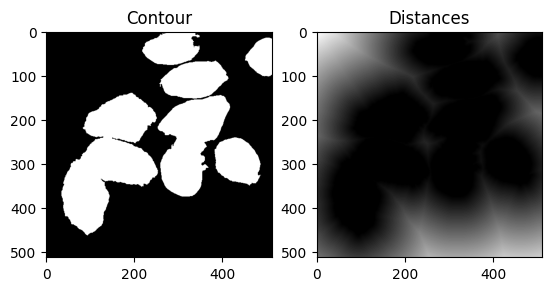

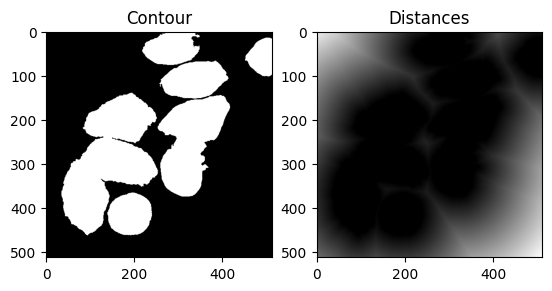

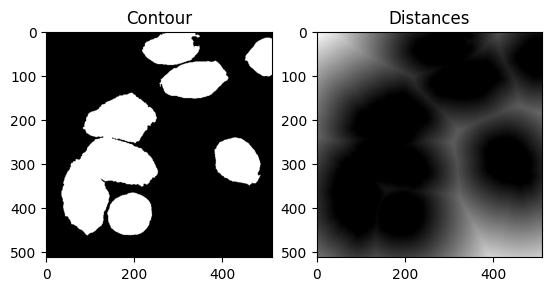

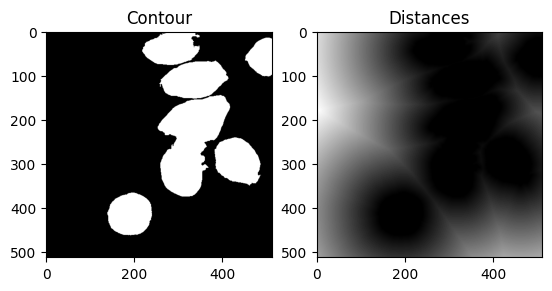

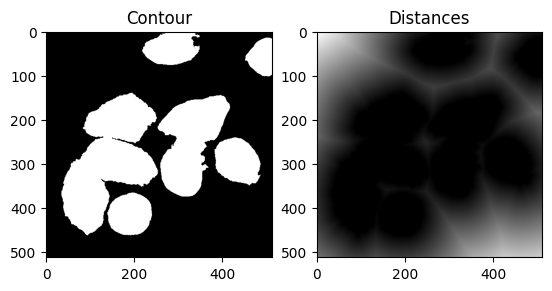

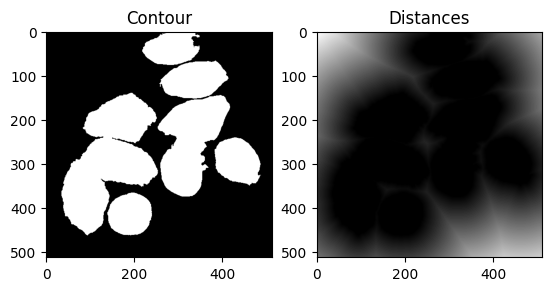

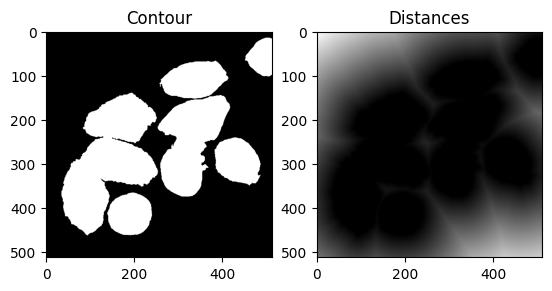

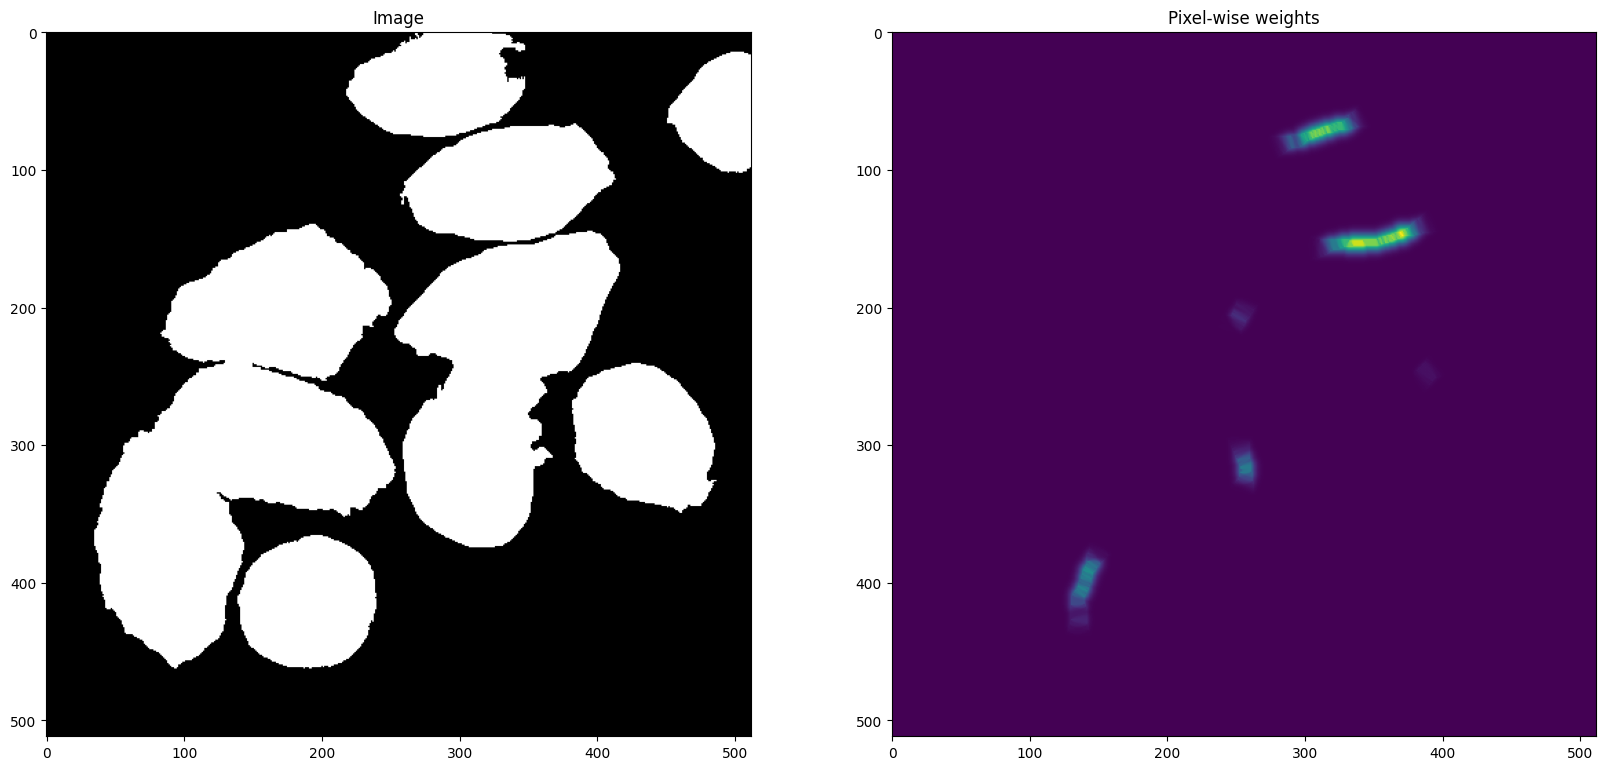

In [9]:
def weight_mapper(label, w0=10, sigma=5, plot=False):
    label = label.astype(np.uint8)
    contours, _ = cv2.findContours(label, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours_minus_one = [
        cv2.drawContours(np.zeros_like(label),
                         contours[:i] + contours[i+1:],
                         -1, 1, -1)
        for i in range(len(contours))
    ]

    dists = [
        cv2.distanceTransform((c == 0).astype(np.uint8), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
        for c in contours_minus_one
    ]

    if plot:
      for c, d in zip(contours_minus_one, dists):
          fig, axs = plt.subplots(1, 2)
          plot_img(axs[0], c, "Contour")
          plot_img(axs[1], d, "Distances")
          plt.show()

    stacked = np.stack(dists, axis=0)
    d0, d1 = np.min(stacked, axis=0), np.max(stacked, axis=0)

    _, counts = np.unique(label, return_counts=True)
    freq = counts / label.size

    return w0 * np.exp(-np.square(d0 + d1) / (2 * sigma**2))


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, outputs, targets):
        targets = targets.float()
        outputs = torch.sigmoid(outputs[:,:1])

        numerator = 2 * outputs * targets + 0.1
        denominator = outputs + targets + 0.1

        return 1 - numerator / denominator


class PixelwiseWeightedLoss(nn.Module):
    def __init__(self, weight_mapper, loss_factory):
        super(PixelwiseWeightedLoss, self).__init__()
        self.weight_mapper = weight_mapper
        self.loss_factory = loss_factory

    def forward(self, outputs, targets):
        weights = torch.tensor(np.array([self.weight_mapper(t.cpu().numpy()) for t in targets]))
        weights = weights.to(device)

        loss = self.loss_factory()(outputs, targets)
        return torch.mean(loss * weights)


img = load_images(Path("DIC-C2DH-HeLa") / "01_ST" / "SEG", n=1)[0]
weights = weight_mapper(img != 0, plot=True)

fix, axs = plt.subplots(1, 2, figsize=(20,20))
plot_img(axs[0], img != 0, "Image")
plot_img(axs[1], weights, cmap="viridis", title="Pixel-wise weights")

In [10]:
class UNetTrainer():
    def __init__(self, model, lr_scheduler, loss_function, device):
        self.model = model.to(device)
        self.lr_scheduler = lr_scheduler
        self.optimizer = lr_scheduler.optimizer
        self.loss_function = loss_function
        self.device = device
        self.total_epochs = 0
        self.total_iterations = 0

        self.training_losses = []
        self.validation_losses = []


    def train(self, epochs, dataloader_train, dataloader_val):
        print("Starting training...")
        self.model.train()
        for epoch in range(epochs):
            training_loss = 0
            for input, target in dataloader_train:
                input = input.to(self.device)
                target = target.to(self.device)


                output = self.model(input)
                loss = self.loss_function(output, target[:,0].long())

                training_loss += loss.item()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.total_iterations += 1


            validation_loss = self.validate(dataloader_val)
            if self.lr_scheduler is not None:
                self.lr_scheduler.step(validation_loss)

            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"Epoch: [{epoch + 1}/{epochs}],",
                  f"Total iterations: {self.total_iterations},",
                  f'Current learning rate: {current_lr},',
                  f"Training Loss: {training_loss / len(dataloader_train)},",
                  f"Validation Loss: {validation_loss/ len(dataloader_val)}",)

            self.total_epochs += 1

            self.training_losses.append(training_loss / len(dataloader_train))
            self.validation_losses.append(validation_loss / len(dataloader_val))

    def validate(self, dataloader):
        self.model.eval()
        validation_loss = 0
        for data in dataloader:
            input, target = data

            input = input.to(self.device)
            target = target.to(self.device)

            output = self.model(input)
            loss = self.loss_function(output, target[:,0].long())

            validation_loss += loss.item()

        self.model.train()
        return validation_loss


In [11]:
def collate(batch):
    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch, 0)
    elif isinstance(batch[0], slice):
        return batch
    elif isinstance(batch[0], tuple):
        return [collate(obj) for obj in zip(*batch)]


class GridSearchCVSelection:
    def __init__(self,
                folds,
                model_type,
                params_dict,
                trainer_type,
                optimizer_type,
                lr_scheduler_type,
                loss_type,
                optimizer_params={},
                lr_scheduler_params={}):
      self.folds = folds
      self.model_type = model_type
      self.params_dict = params_dict
      self.trainer_type = trainer_type
      self.optimizer_type = optimizer_type
      self.lr_scheduler_type = lr_scheduler_type
      self.loss_type = loss_type
      self.optimizer_params = optimizer_params
      self.lr_scheduler_params = lr_scheduler_params

    def _cross_validate(self, dataset, epochs, trainer_factory):
        kf = KFold(self.folds)
        loss = 0
        for train_idx, val_idx in kf.split(dataset):
            train_loader = DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(train_idx),
                collate_fn=collate
            )
            val_loader = DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(val_idx),
                collate_fn=collate
            )
            trainer = trainer_factory()
            trainer.train(epochs, train_loader, val_loader)
            loss += trainer.validation_losses[-1]
        return loss / self.folds

    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")


    def run(self,
            dataset,
            device,
            epochs):

        best_params = None
        best_loss = np.inf

        prod = list(product(*self.params_dict.values()))
        keys = self.params_dict.keys()
        configs = [dict(zip(keys, e)) for e in prod]

        for model_params in configs:
            print("Current parameters:", model_params)
            def trainer_factory():
                model = self.model_type(**model_params)
                model.apply(self._weights_init)
                return self.trainer_type(
                    model,
                    self.lr_scheduler_type(
                        self.optimizer_type(model.parameters(), **self.optimizer_params),
                        **self.lr_scheduler_params
                    ),
                    self.loss_type(),
                    device
                )

            loss = self._cross_validate(dataset, epochs, trainer_factory)
            if loss < best_loss:
                best_loss = loss
                best_params = model_params

        self.best_params = best_params
        return best_params, best_loss


    def train_best_model(self, epochs, train_loader, val_loader):
        model = self.model_type(**self.best_params)
        model.apply(self._weights_init)
        trainer = self.trainer_type(
            model,
            self.lr_scheduler_type(
                self.optimizer_type(model.parameters(), **self.optimizer_params),
                **self.lr_scheduler_params
            ),
            self.loss_type(),
            device
        )
        trainer.train(epochs, train_loader, val_loader)
        return trainer


In [12]:
model_selector = GridSearchCVSelection(
    folds=3,
    model_type=UNet2d,
    params_dict={
      "input_dim": [1],
      "output_dim": [2],
      "hidden_layers": [3,5,7],
      "first_hidden_dim": [32,64],
      "kernel_size": [3],
      "skip_mode": ["add", "concat"],
      "upsampling_mode": ["interpolate", "transpose"],
      "dropout": [.5],
    },
    trainer_type=UNetTrainer,
    optimizer_type=optim.Adam,
    lr_scheduler_type=optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={
        "mode": "min",
        "factor": 0.1,
        "patience": 50,
    },
    loss_type=partial(PixelwiseWeightedLoss, loss_factory=nn.CrossEntropyLoss, weight_mapper=weight_mapper)
)

best_params, loss = model_selector.run(
    dataset=dic_data,
    device=device,
    epochs=20,
)

print("Best parameters:", best_params)
print("Loss:", loss)

Current parameters: {'input_dim': 1, 'output_dim': 2, 'hidden_layers': 3, 'first_hidden_dim': 32, 'kernel_size': 3, 'skip_mode': 'add', 'upsampling_mode': 'interpolate', 'dropout': 0.5}
Starting training...
Epoch: [1/20], Total iterations: 15, Current learning rate: 0.001, Training Loss: 0.10297563821077346, Validation Loss: 0.0819236971437931
Epoch: [2/20], Total iterations: 30, Current learning rate: 0.001, Training Loss: 0.0883940023680528, Validation Loss: 0.0722680042963475
Epoch: [3/20], Total iterations: 45, Current learning rate: 0.001, Training Loss: 0.07968102941910425, Validation Loss: 0.07415757235139608
Epoch: [4/20], Total iterations: 60, Current learning rate: 0.001, Training Loss: 0.07184165169795355, Validation Loss: 0.060152396094053984
Epoch: [5/20], Total iterations: 75, Current learning rate: 0.001, Training Loss: 0.06991592248280844, Validation Loss: 0.06999531667679548
Epoch: [6/20], Total iterations: 90, Current learning rate: 0.001, Training Loss: 0.06847399100

In [16]:
full_dic_data = load_datasets(
    Path("DIC-C2DH-HeLa"),
    phase="train",
    patch_size=patch_size,
    stride=stride,
    padding=padding,
    transforms=test_transf,
)

train_dataset, val_dataset = torch.utils.data.random_split(full_dic_data, [0.8, 0.2])
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate
)

trainer = model_selector.train_best_model(20, train_loader, val_loader)

Starting training...
Epoch: [1/20], Total iterations: 152, Current learning rate: 0.001, Training Loss: 0.05766573688628054, Validation Loss: 0.04049901286826322
Epoch: [2/20], Total iterations: 304, Current learning rate: 0.001, Training Loss: 0.03629893261179524, Validation Loss: 0.03193765829660391
Epoch: [3/20], Total iterations: 456, Current learning rate: 0.001, Training Loss: 0.03114959643541002, Validation Loss: 0.026317928439790483
Epoch: [4/20], Total iterations: 608, Current learning rate: 0.001, Training Loss: 0.026006422466659723, Validation Loss: 0.028187662117967482
Epoch: [5/20], Total iterations: 760, Current learning rate: 0.001, Training Loss: 0.02456879191480479, Validation Loss: 0.02435806415680992
Epoch: [6/20], Total iterations: 912, Current learning rate: 0.001, Training Loss: 0.023921048155324042, Validation Loss: 0.02679436131821651
Epoch: [7/20], Total iterations: 1064, Current learning rate: 0.001, Training Loss: 0.023132488468514855, Validation Loss: 0.0222

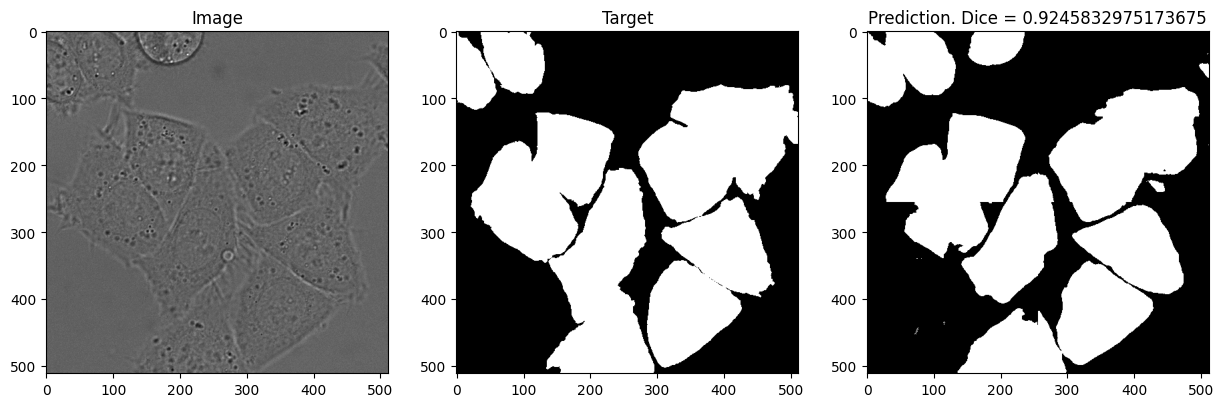

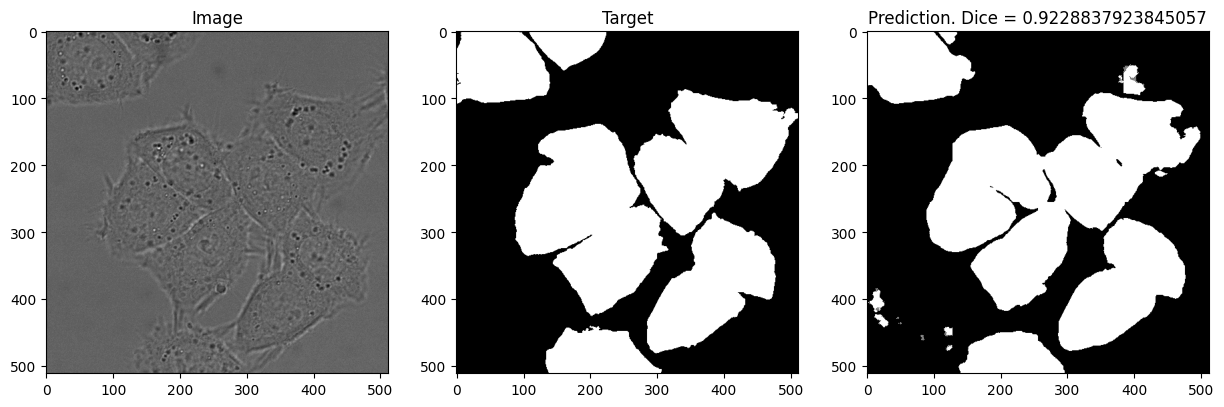

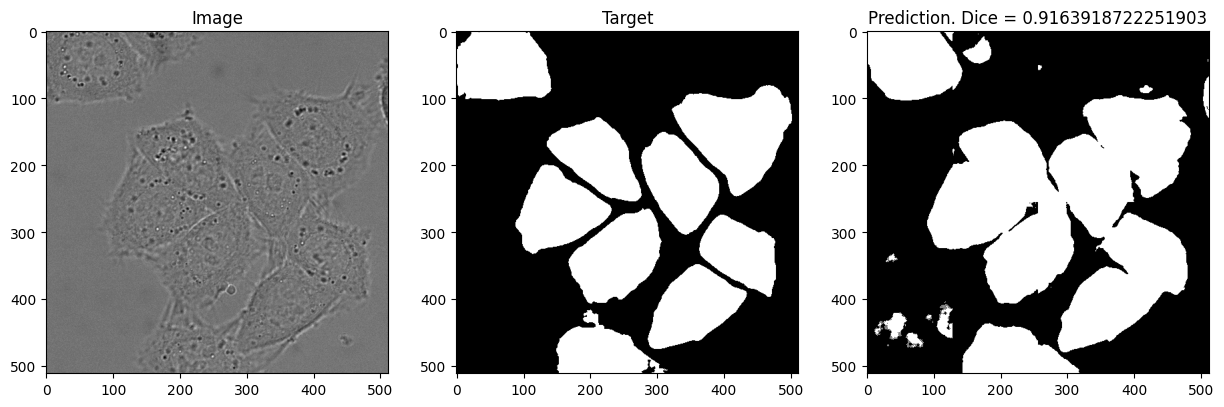

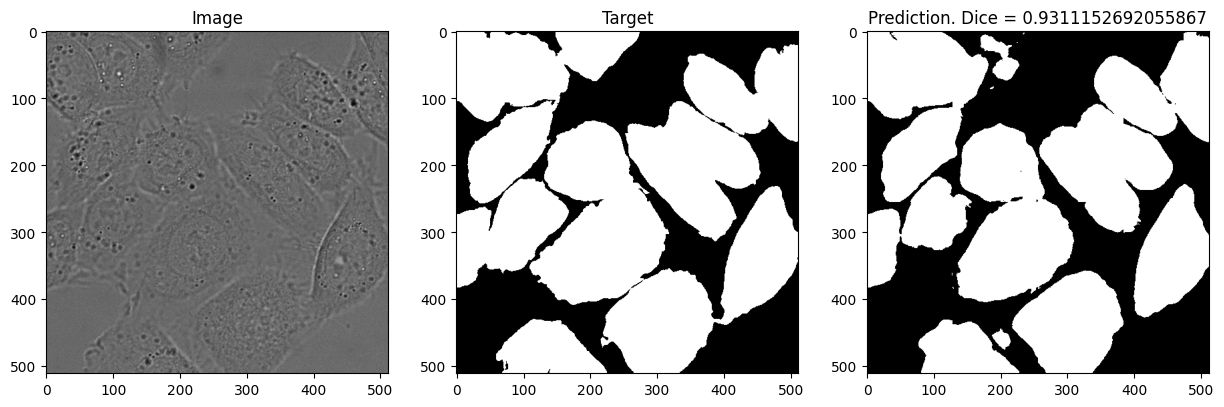

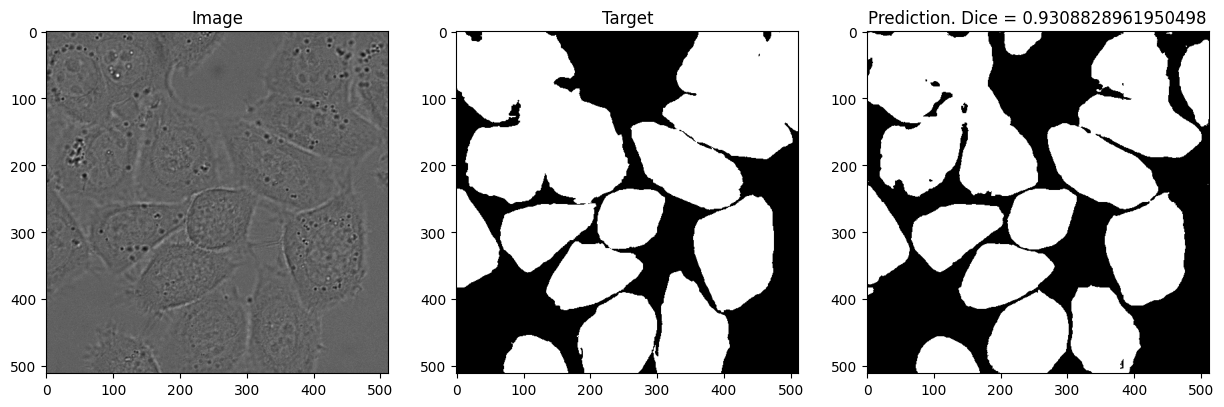

In [18]:
def Dice(pred, gt):
    numerator = 2 * np.sum(pred * gt, axis = (1,2))
    denominator = np.sum(pred, axis = (1,2)) + np.sum(gt, axis = (1,2))
    return np.mean(numerator / denominator)

test_datasets = [load_datasets(Path("DIC-C2DH-HeLa"),
                              phase="test",
                              n=1,
                              seed=i,
                              patch_size=patch_size,
                              stride=stride,
                              padding=padding,
                              transforms=test_transf) for i in range(5)]

for test_ds in test_datasets:
  output, val = trainer.model.predict(test_ds, Dice)
  _, ax = plt.subplots(1, 3, figsize=(15, 5))
  plot_img(ax[0], test_ds.image, title="Image")
  plot_img(ax[1], test_ds.label > 0, title="Target")
  plot_img(ax[2], (output > 0).astype(int), title=f"Prediction. Dice = {val}")
  plt.show()
